# Fetch a random set of tiles from Landsat

The code in this notebook selects a random subset of the landsat tiles listed in landsat5list.py (which are landsat5 tiles that cover the same space & time as the corine dataset).
To use this notebook, you need to have a USGS account, and have the username and password in the USGS_USER and USGS_PASSWORD environment variables, respectively.  The variable landsat5fetch.storage_directory is the directory where the landsat files (both the tar files and the processed tif files) are stored.  Set it to another value if needed.

Towards the bottom of the notebook are recommended methods to make sure that the retrieved tiles are actually useful, and to prevent unuseful ones from being downloaded again.

In [1]:
from landsat5fetch import *
from pathlib import Path

In [2]:
s = get_session()

In [4]:
import numpy as np
import landsat5list
lst = np.array(landsat5list.potential_tiles)
wehave = list(Path(landsat5fetch.storage_directory).glob('*.tif'))
candidates = list(set(lst) - set( [x.stem for x in wehave ]))
print( len(lst), len(wehave), len(candidates) )

1823 39 1784


In [5]:
# USGS seems to have a limit of 20 that it will allow you to request at a time

np.random.shuffle(candidates)
tofetch = list(candidates[:20])
tofetch

['LT05_L1TP_196032_20060508_20180310_01_T1',
 'LT05_L1TP_190018_20060615_20161121_01_T1',
 'LT05_L1TP_188031_20061124_20180309_01_T1',
 'LT05_L1TP_201030_20060714_20180309_01_T1',
 'LT05_L1TP_186026_20060705_20161120_01_T1',
 'LT05_L1TP_189019_20060507_20161122_01_T1',
 'LT05_L1TP_192025_20061019_20161118_01_T1',
 'LT05_L1TP_192016_20060221_20180311_01_T1',
 'LT05_L1TP_188034_20060804_20180309_01_T1',
 'LT05_L1TP_177031_20060417_20180310_01_T1',
 'LT05_L1TP_203032_20060728_20180310_01_T1',
 'LT05_L1TP_192026_20060917_20161118_01_T1',
 'LT05_L1TP_193033_20061010_20180309_01_T1',
 'LT05_L1TP_177036_20060722_20180310_01_T1',
 'LT05_L1TP_201033_20060425_20180309_01_T1',
 'LT05_L1TP_186031_20060721_20180309_01_T1',
 'LT05_L1TP_200029_20060723_20180310_01_T1',
 'LT05_L1TP_187017_20060509_20161121_01_T1',
 'LT05_L1TP_189023_20060507_20161122_01_T1',
 'LT05_L1TP_188019_20060617_20161121_01_T1']

In [6]:
submit_order(list(tofetch))
# Note: if you get a 400 (BAD REQUEST) error, it is probably because you've exceeded some resource limit, not actually a bad request

'espa-draperd@acm.org-06132019-012013-725'

In [7]:
get_open_orders()

['espa-draperd@acm.org-06132019-012013-725',
 'espa-draperd@acm.org-06102019-013625-550']

In [14]:
downloaded = download_available_results()
len(downloaded)

order espa-draperd@acm.org-06132019-012013-725
LT05_L1TP_196032_20060508_20180310_01_T1: already have
LT05_L1TP_177031_20060417_20180310_01_T1: already have
LT05_L1TP_189019_20060507_20161122_01_T1: already have
LT05_L1TP_203032_20060728_20180310_01_T1: already have
LT05_L1TP_177036_20060722_20180310_01_T1: already have
LT05_L1TP_188031_20061124_20180309_01_T1: already have
LT05_L1TP_192026_20060917_20161118_01_T1: already have
LT05_L1TP_192016_20060221_20180311_01_T1: already have
downloading LT05_L1TP_192025_20061019_20161118_01_T1 ................................................................................done
LT05_L1TP_200029_20060723_20180310_01_T1: already have
LT05_L1TP_188034_20060804_20180309_01_T1: already have
LT05_L1TP_201033_20060425_20180309_01_T1: already have
LT05_L1TP_186026_20060705_20161120_01_T1: already have
LT05_L1TP_187017_20060509_20161121_01_T1: already have
LT05_L1TP_190018_20060615_20161121_01_T1: already have
LT05_L1TP_189023_20060507_20161122_01_T1: alr

1

In [ ]:
# Warning: I wrote this for guidance, but I haven't actually checked that it works yet...
files_to_process = [ Path('/home/usgs/landsat5') / (x + ".tar.gz") for x in downloaded ]

In [ ]:
# ls5munge.sh processes the data from the form we get it from landsat (a gzipped tar file) into the form we will use (a tif file)
# Ideally we'd do the landsat tile processing from here in the notebook, but it doesn't work, because I have not found any way to activate the right conda environment 
# from within a notebook. So for now, you have to open a terminal, activate fastai environment, then run ls5munge.sh manually.
#
# Usage:  ./ls5munge.sh [full-paths-to-files-to-proess]

In [4]:
import numpy as np
from pathlib import Path
import sys
sys.path.append('/home/firewise/')  # add parent to python path so that we can import some tools...
from multispectral import corine
from multispectral import coords
from multispectral import tools
import rasterio
tools.set_figure_width(20)

In [15]:
#tocheck = list(Path('/home/usgs/landsat5').glob('*.tif'))
tocheck = [ Path('/home/usgs/landsat5') / (x + ".tif") for x in downloaded ]
len(tocheck)

1

In [16]:
# Not all the files in landsat5list.py will actually be useful.
# The checking here is similar to what we do in window generation, but in this case we are looking
# at the *entire* landsat file at once.  This loop will find tiles that can't have any valid windows
# (e.g. because they only intersect an empty part of corine).
# Files identified here should both be removed from the storage directory and commented out of landsat5list.py --- in fact
# all files with the same pathrow combo --- so that we don't download them again.

failed = []
for file in tocheck:
    fp = rasterio.open(file)
    cp = corine.fetch_corine(fp.crs)
    geo_common = coords.geo_window_intersect(fp.bounds,cp.bounds)
    if geo_common is None:
        # This case shouldn't happen, and probably should be investigated.
        failed.append(file)
        print("{} does not intersect {}".format(file.name, cp.name))
        continue
    
    fp_window = coords.geo_to_pixel(fp,geo_common)
    cp_window = coords.geo_to_pixel(cp,geo_common)
    (fp_window,cp_window) = smudge(fp_window,cp_window)
    
    # check to see if the non-nodata bits overlap
    fp_patch = fp.read(7, window=fp_window)
    if not fp_patch.any():
        failed.append(file)
        print("{} is empty in intersection".format(file.name))
        continue
        
    cp_patch = cp.read(1, window=cp_window)
    if not cp_patch.any():
        failed.append(file)
        print("{} intersects empty part of corine".format(file.name))
        continue
    
    common_data = np.logical_and(fp_patch,cp_patch)
    if not common_data.any():
        failed.append(file)
        print("{} and {} have no common data".format(file.name, cp.name))
    

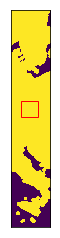

In [17]:
# Show the location of the failed tiles.  You should generally expect them to be visibly outside or on the edge of the corine data.
# If they are not, it may mean the landsat data is corrupted, or a bug, or...

for file in failed:
    fp = rasterio.open(file)
    cp = corine.fetch_corine(fp.crs)
    tools.showband(cp,1,showrect=coords.geo_to_pixel(cp,fp.bounds).flatten())